# Brain Tumor Segmentation

## (Un)Healthy Brain Classification

In [1]:
import os
import cv2
import urllib
from PIL import Image
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Pytorch libraries and subsidiaries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda as cuda
import torchvision as tv
from torchvision import transforms
from torchsummary import summary # allows for keras-like summaries of models in pytorch

### Check CUDA Capability and Set Device

In [2]:
if cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on ' + cuda.get_device_name(device))
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on NVIDIA GeForce GTX 1070


### Load Pretrained Model and Set to Device

In [3]:
%%capture --no-stdout

# Load one of our pre-trained models for brain segmentation
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True)

# Set our model to run on the GPU if available and the CPU if not
model = model.to(device)

In [4]:
summary(model) # Get some stats on our pretrained model

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       864
|    └─BatchNorm2d: 2-2                  64
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       9,216
|    └─BatchNorm2d: 2-5                  64
|    └─ReLU: 2-6                         --
├─MaxPool2d: 1-2                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-7                       18,432
|    └─BatchNorm2d: 2-8                  128
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      36,864
|    └─BatchNorm2d: 2-11                 128
|    └─ReLU: 2-12                        --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Conv2d: 2-13                      73,728
|    └─BatchNorm2d: 2-14                 256
|    └─ReLU: 2-15                        --
|    └─Conv2d: 2-16                      147,456
|  

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       864
|    └─BatchNorm2d: 2-2                  64
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       9,216
|    └─BatchNorm2d: 2-5                  64
|    └─ReLU: 2-6                         --
├─MaxPool2d: 1-2                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-7                       18,432
|    └─BatchNorm2d: 2-8                  128
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      36,864
|    └─BatchNorm2d: 2-11                 128
|    └─ReLU: 2-12                        --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Conv2d: 2-13                      73,728
|    └─BatchNorm2d: 2-14                 256
|    └─ReLU: 2-15                        --
|    └─Conv2d: 2-16                      147,456
|  

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')


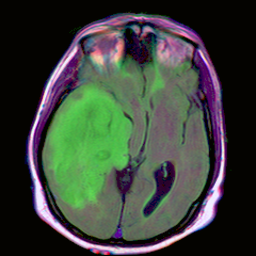

In [6]:
# Download an example image
url, filename = ("https://github.com/mateuszbuda/brain-segmentation-pytorch/raw/master/assets/TCGA_CS_4944.png", "example.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

input_image = Image.open(filename)
m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=m, std=s),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model = model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

print(torch.round(output[0]))
display(input_image)

### Create Pandas Dataframe of Images

In [7]:
tumor_dir = 'brain-tumor-dataset/Brain Tumor'
healthy_dir = 'brain-tumor-dataset/Healthy'
dirlist = [tumor_dir, healthy_dir]
classes = ['Brain Tumor', 'Healthy']
filepaths = []
labels = []
for d,c in zip(dirlist, classes):
    flist = os.listdir(d)
    for f in flist:
        fpath = os.path.join (d,f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

Fseries = pd.Series(filepaths, name='file_paths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries,Lseries], axis=1)
df = pd.DataFrame(np.array(df).reshape(4600,2), columns = ['file_paths', 'labels'])
print(df['labels'].value_counts())

filepaths:  4600    labels:  4600
Brain Tumor    2513
Healthy        2087
Name: labels, dtype: int64
